### Import data

In [1]:
import sframe
loans = sframe.SFrame('lending-club-data.gl/')

[INFO] sframe.cython.cy_server: SFrame v2.1 started. Logging /tmp/sframe_server_1483380337.log


In [2]:
loans.column_names()

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'is_inc_v',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'not_compliant',
 'status',
 'inactive_loans',
 'bad_loans',
 'emp_length_num',
 'grade_num',
 'sub_grade_num',
 'delinq_2yrs_zero',
 'pub_rec

Modifying the target column

In [3]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.remove_column('bad_loans')

Selecting features

In [4]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies
             'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

In [5]:
loans, loans_with_na = loans[[target] + features].dropna_split()

# Count the number of rows with missing data
num_rows_with_na = loans_with_na.num_rows()
num_rows = loans.num_rows()
print 'Dropping %s observations; keeping %s ' % (num_rows_with_na, num_rows)

Dropping 29 observations; keeping 122578 


Make sure classes are balanced

In [6]:
safe_loans_raw = loans[loans[target] == 1]
risky_loans_raw = loans[loans[target] == -1]

# Undersample the safe loans.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
safe_loans = safe_loans_raw.sample(percentage, seed = 1)
risky_loans = risky_loans_raw
loans_data = risky_loans.append(safe_loans)

print "Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data))
print "Percentage of risky loans                :", len(risky_loans) / float(len(loans_data))
print "Total number of loans in our new dataset :", len(loans_data)

Percentage of safe loans                 : 0.502247166849
Percentage of risky loans                : 0.497752833151
Total number of loans in our new dataset : 46503


One-hot encoding

In [7]:
loans_data = risky_loans.append(safe_loans)

categorical_variables = []
for feat_name, feat_type in zip(loans_data.column_names(), loans_data.column_types()):
    if feat_type == str:
        categorical_variables.append(feat_name)

for feature in categorical_variables:
    loans_data_one_hot_encoded = loans_data[feature].apply(lambda x: {x: 1})
    loans_data_unpacked = loans_data_one_hot_encoded.unpack(column_name_prefix=feature)

    # Change None's to 0's
    for column in loans_data_unpacked.column_names():
        loans_data_unpacked[column] = loans_data_unpacked[column].fillna(0)

    loans_data.remove_column(feature)
    loans_data.add_columns(loans_data_unpacked)

features = loans_data.column_names()
features.remove(target)
print features

['sub_grade_num', 'short_emp', 'emp_length_num', 'dti', 'payment_inc_ratio', 'delinq_2yrs', 'delinq_2yrs_zero', 'inq_last_6mths', 'last_delinq_none', 'last_major_derog_none', 'open_acc', 'pub_rec', 'pub_rec_zero', 'revol_util', 'total_rec_late_fee', 'int_rate', 'total_rec_int', 'annual_inc', 'funded_amnt', 'funded_amnt_inv', 'installment', 'grade.A', 'grade.B', 'grade.C', 'grade.D', 'grade.E', 'grade.F', 'grade.G', 'home_ownership.MORTGAGE', 'home_ownership.OTHER', 'home_ownership.OWN', 'home_ownership.RENT', 'purpose.car', 'purpose.credit_card', 'purpose.debt_consolidation', 'purpose.home_improvement', 'purpose.house', 'purpose.major_purchase', 'purpose.medical', 'purpose.moving', 'purpose.other', 'purpose.small_business', 'purpose.vacation', 'purpose.wedding']


In [8]:
train_data, validation_data = loans_data.random_split(.8, seed=1)

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy

In [10]:
train_data_label = train_data.select_column(target).to_numpy()
train_data_matrix = train_data.select_columns(features).to_numpy()
validation_data_label = validation_data.select_column(target).to_numpy()
validation_data_matrix = validation_data.select_columns(features).to_numpy()

In [11]:
model_5 = GradientBoostingClassifier(max_depth=6, n_estimators=5)

In [12]:
model_5.fit(train_data_matrix, train_data_label)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=5, presort='auto',
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

Making Predictions

In [13]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

Columns:
	safe_loans	int
	sub_grade_num	float
	short_emp	int
	emp_length_num	int
	dti	float
	payment_inc_ratio	float
	delinq_2yrs	int
	delinq_2yrs_zero	int
	inq_last_6mths	int
	last_delinq_none	int
	last_major_derog_none	int
	open_acc	int
	pub_rec	int
	pub_rec_zero	int
	revol_util	float
	total_rec_late_fee	float
	int_rate	float
	total_rec_int	float
	annual_inc	int
	funded_amnt	int
	funded_amnt_inv	int
	installment	float
	grade.A	int
	grade.B	int
	grade.C	int
	grade.D	int
	grade.E	int
	grade.F	int
	grade.G	int
	home_ownership.MORTGAGE	int
	home_ownership.OTHER	int
	home_ownership.OWN	int
	home_ownership.RENT	int
	purpose.car	int
	purpose.credit_card	int
	purpose.debt_consolidation	int
	purpose.home_improvement	int
	purpose.house	int
	purpose.major_purchase	int
	purpose.medical	int
	purpose.moving	int
	purpose.other	int
	purpose.small_business	int
	purpose.vacation	int
	purpose.wedding	int

Rows: 4

Data:
+------------+---------------+-----------+----------------+-------+-------------------+
| safe_loans | sub_grade_num | short_emp | emp_length_num |  dti  | payment_inc_ratio |
+------------+---------------+-----------+----------------+-------+-------------------+
|     1      |      0.2      |     0     |       3        | 29.44 |      6.30496      |
|     1      |      0.6      |     1     |       1        | 12.19 |      13.4952      |
|     -1     |      0.4      |     0     |       3        | 13.97 |      2.96736      |
|     -1     |      1.0      |     0     |       11       | 16.33 |      1.90524      |
+------------+---------------+-----------+----------------+-------+-------------------+
+-------------+------------------+----------------+------------------+-----------------------+
| delinq_2yrs | delinq_2yrs_zero | inq_last_6mths | last_delinq_none | last_major_derog_none |
+-------------+------------------+----------------+------------------+-----------------------+
|      0      |        1         |       0        |        1         |           1           |
|      0      |        1         |       0        |        1         |           1           |
|      3      |        0         |       0        |        0         |           1           |
|      0      |        1         |       0        |        1         |           1           |
+-------------+------------------+----------------+------------------+-----------------------+
+----------+---------+--------------+------------+--------------------+----------+
| open_acc | pub_rec | pub_rec_zero | revol_util | total_rec_late_fee | int_rate |
+----------+---------+--------------+------------+--------------------+----------+
|    8     |    0    |      1       |    93.9    |        0.0         |   9.91   |
|    8     |    0    |      1       |    59.1    |        0.0         |  11.71   |
|    14    |    0    |      1       |    59.5    |        0.0         |  16.77   |
|    17    |    0    |      1       |    62.1    |        0.0         |   8.9    |
+----------+---------+--------------+------------+--------------------+----------+
+---------------+------------+-------------+-----+
| total_rec_int | annual_inc | funded_amnt | ... |
+---------------+------------+-------------+-----+
|     823.48    |   92000    |    15000    | ... |
|    1622.21    |   25000    |     8500    | ... |
|     719.11    |   50004    |     5000    | ... |
|     696.99    |   100000   |     5000    | ... |
+---------------+------------+-------------+-----+
[4 rows x 45 columns]

**Quiz question:** What percentage of the predictions on sample_validation_data did model_5 get correct?

In [14]:
model_5.predict(sample_validation_data.select_columns(features).to_numpy())

array([ 1,  1, -1,  1])

In [15]:
sample_validation_data.select_column(target)

dtype: int
Rows: 4
[1, 1, -1, -1]

**Quiz Question:** Which loan has the highest probability of being classified as a safe loan?

In [16]:
model_5.predict_proba(sample_validation_data.select_columns(features).to_numpy())[:,1]

array([ 0.58357669,  0.53050311,  0.46192208,  0.60408361])

Evaluating the model on the validation data

In [17]:
validation_prediction = model_5.predict(validation_data_matrix)

In [18]:
from sklearn.metrics import confusion_matrix
print 'False positive: ', confusion_matrix(validation_data_label, validation_prediction)[1][0]
print 'False negative: ', confusion_matrix(validation_data_label, validation_prediction)[0][1]

False positive:  1491
False negative:  1653


In [19]:
print 'Accuracy of the model: ', model_5.score(validation_data_matrix, validation_data_label)

Accuracy of the model:  0.661352865144


In [20]:
cost = 1652*20000 + 1491*10000
print cost

47950000


In [21]:
validation_prob = model_5.predict_proba(validation_data_matrix)[:,1]

In [22]:
validation_data.add_column(sframe.SArray(validation_prob, float), name='prediction')

safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero
-1,0.4,0,3,13.97,2.96736,3,0
-1,1.0,0,11,16.33,1.90524,0,1
-1,0.4,0,5,12.48,3.57024,0,1
-1,0.4,0,11,23.18,14.7009,0,1
-1,0.2,0,3,7.83,11.0486,0,1
-1,0.2,0,7,16.63,9.2544,0,1
-1,0.6,0,4,6.62,9.2814,0,1
-1,0.4,0,9,8.4,7.05789,0,1
-1,0.2,0,4,15.0,14.8264,0,1
-1,0.2,0,6,13.22,6.77784,0,1


In [23]:
validation_data.sort('prediction', ascending=False)

safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero
-1,0.4,0,4,12.73,12.167,0,1
1,0.6,0,11,3.53,3.06281,0,1
1,0.6,0,11,2.4,2.49545,0,1
1,0.4,0,8,8.87,4.4456,0,1
1,0.4,0,11,10.95,3.02852,0,1
1,0.2,0,7,15.92,0.717964,0,1
1,0.2,0,2,8.18,6.032,0,1
-1,0.2,0,11,8.73,7.49691,0,1
1,0.8,0,2,13.65,1.75065,0,1
1,0.4,0,7,11.08,2.24278,0,1


In [24]:
validation_data.sort('prediction')

safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero
-1,0.8,0,2,8.66,17.6251,0,1
-1,0.8,1,1,7.37,16.6207,0,1
-1,1.0,0,3,8.53,14.628,0,1
-1,0.4,0,3,21.9,7.1876,1,0
-1,0.8,0,9,8.54,7.48113,0,1
-1,0.2,0,11,11.21,4.23624,0,1
-1,1.0,0,2,4.7,5.55965,0,1
-1,0.8,1,1,26.11,5.75952,1,0
-1,0.6,0,5,10.81,4.80254,1,0
-1,0.2,0,11,18.81,2.7219,0,1


In [25]:
model_10 = GradientBoostingClassifier(n_estimators=10, max_depth=6)
model_50 = GradientBoostingClassifier(n_estimators=50, max_depth=6)
model_100 = GradientBoostingClassifier(n_estimators=100, max_depth=6)
model_200 = GradientBoostingClassifier(n_estimators=200, max_depth=6)
model_500 = GradientBoostingClassifier(n_estimators=500, max_depth=6)

In [26]:
model_10.fit(train_data_matrix,train_data_label)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [27]:
model_50.fit(train_data_matrix,train_data_label)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [28]:
model_100.fit(train_data_matrix,train_data_label)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [29]:
model_200.fit(train_data_matrix,train_data_label)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [30]:
model_500.fit(train_data_matrix,train_data_label)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [35]:
validation_err_10 = 1 - model_10.score(validation_data_matrix, validation_data_label)
validation_err_50 = 1 - model_50.score(validation_data_matrix, validation_data_label)
validation_err_100 = 1 - model_100.score(validation_data_matrix, validation_data_label)
validation_err_200 = 1 - model_200.score(validation_data_matrix, validation_data_label)
validation_err_500 = 1 - model_500.score(validation_data_matrix, validation_data_label)

print 'Validation error with 10 estimators: ', validation_err_10
print 'Validation error with 50 estimators: ', validation_err_50
print 'Validation error with 100 estimators: ', validation_err_100
print 'Validation error with 200 estimators: ', validation_err_200
print 'Validation error with 500 estimators: ', validation_err_500

Validation error with 10 estimators:  0.334554071521
Validation error with 50 estimators:  0.318181818182
Validation error with 100 estimators:  0.310749676863
Validation error with 200 estimators:  0.310318828091
Validation error with 500 estimators:  0.310534252477


In [32]:
train_err_10 = 1 - model_10.score(train_data_matrix, train_data_label)
train_err_50 = 1 - model_50.score(train_data_matrix, train_data_label)
train_err_100 = 1 - model_100.score(train_data_matrix, train_data_label)
train_err_200 = 1 - model_200.score(train_data_matrix, train_data_label)
train_err_500 = 1 - model_500.score(train_data_matrix, train_data_label)

print 'Train error with 10 estimators: ', train_err_10
print 'Train error with 50 estimators: ', train_err_50
print 'Train error with 100 estimators: ', train_err_100
print 'Train error with 200 estimators: ', train_err_200
print 'Train error with 500 estimators: ', train_err_500

Train error with 10 estimators:  0.32891802574
Train error with 50 estimators:  0.283242429942
Train error with 100 estimators:  0.253633896666
Train error with 200 estimators:  0.214970848223
Train error with 500 estimators:  0.136811843413


In [36]:
training_errors = [train_err_10, train_err_50, train_err_100, train_err_200, train_err_500]
validation_errors = [validation_err_10, validation_err_50, validation_err_100, validation_err_200, validation_err_500]

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

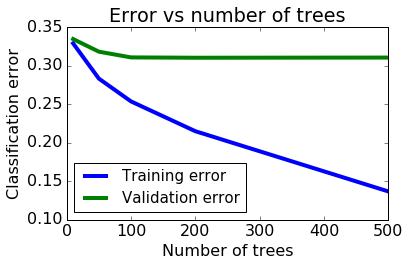

In [38]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')